In [ ]:
!pip install tf-keras-vis
!pip install tf-keras-vis tensorflow

!git clone https://github.com/keisen/tf-keras-vis.git
!cd tf-keras-vis
!pip install -e .[develop] tensorflow

In [1]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from keras.models import load_model

In [2]:
import matplotlib.pyplot as plt
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


In [4]:
model = load_model('vgg16_dt_augmented.h5')

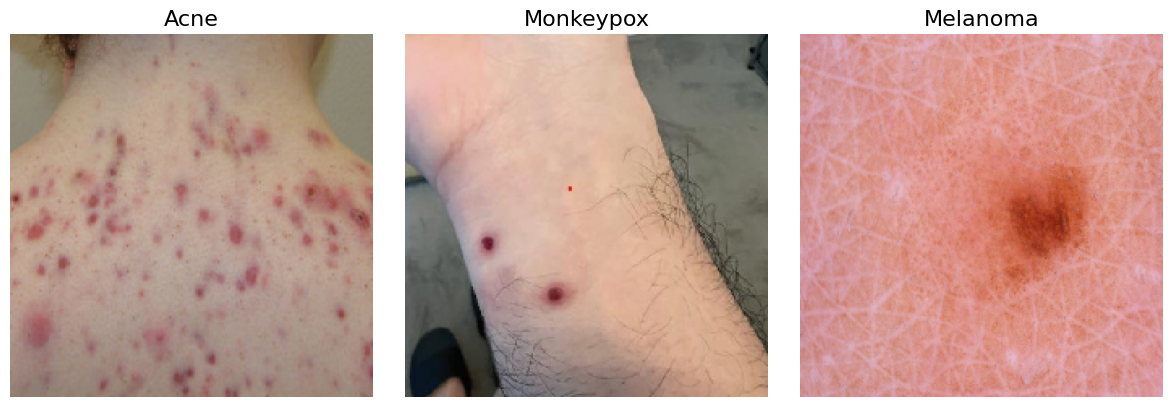

In [23]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Acne', 'Monkeypox', 'Melanoma']

# Load images and Convert them to a Numpy array
img1 = load_img('images\Acne (2).jpg', target_size=(224, 224))
img2 = load_img('images\Moneypox_80.jpg', target_size=(224, 224))
img3 = load_img('images\Melanoma (27).jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [24]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [25]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.

#Key classes for the images
score = CategoricalScore([0, 3, 2])


## Vanila Saliency

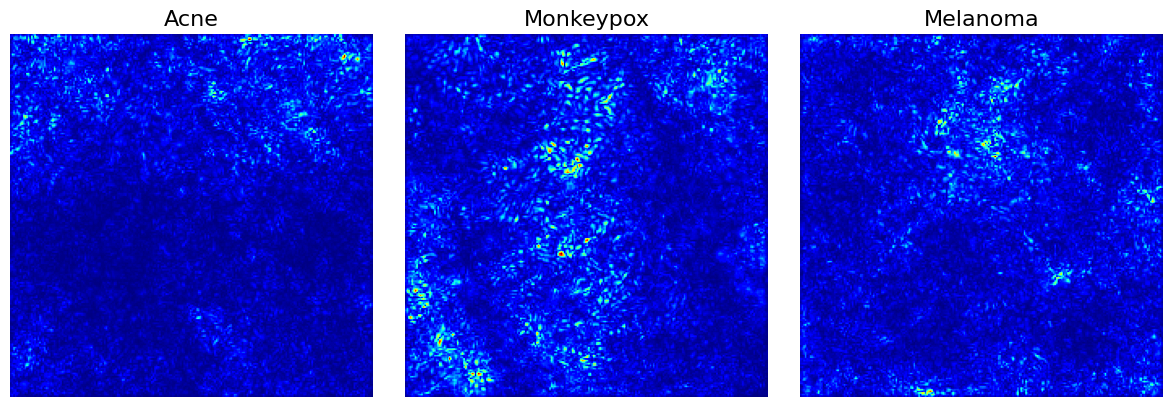

CPU times: total: 10.5 s
Wall time: 4.91 s


In [26]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

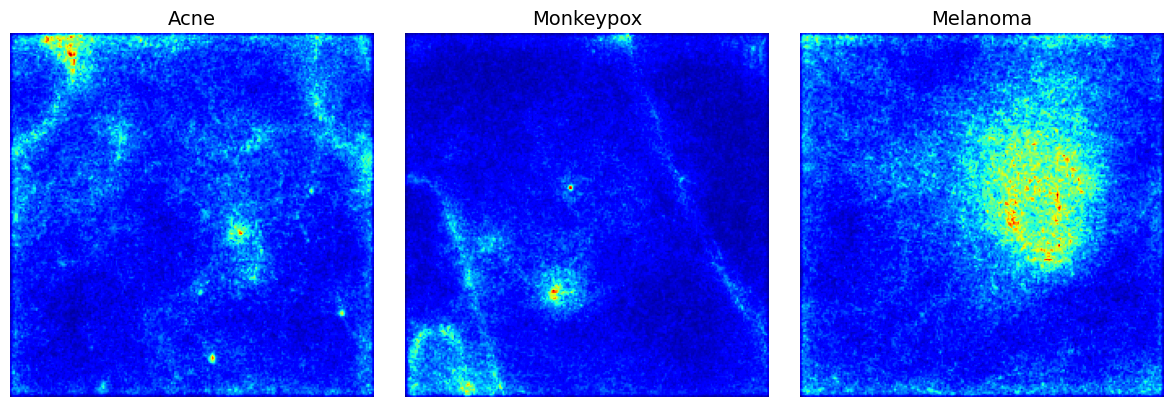

CPU times: total: 3min 28s
Wall time: 1min 17s


In [27]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

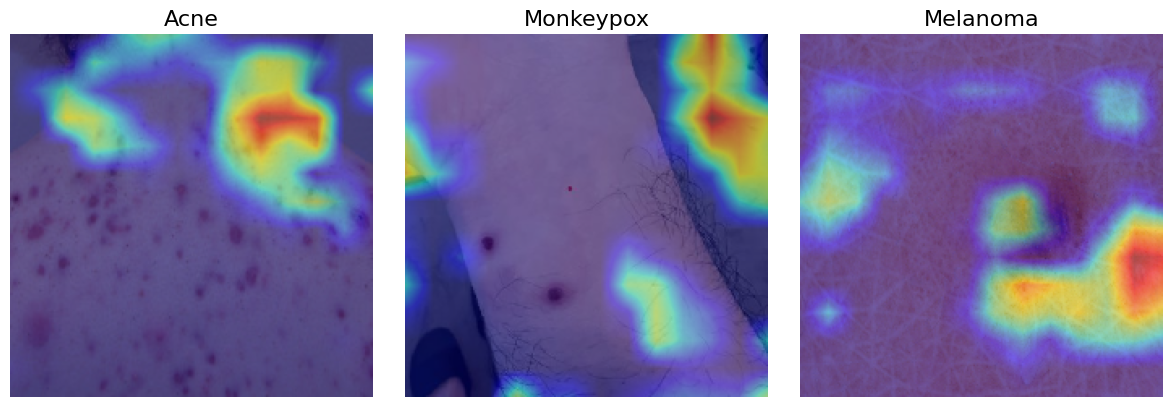

CPU times: total: 11.6 s
Wall time: 4.75 s


In [28]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GradCAM++

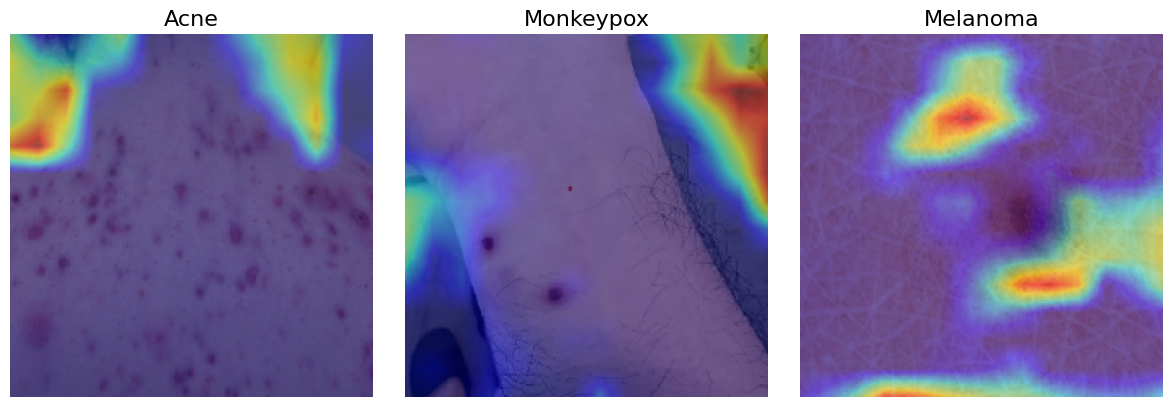

CPU times: total: 12.1 s
Wall time: 5.21 s


In [29]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

## ScoreCAM

48/48 [==============================] - 492s 10s/step


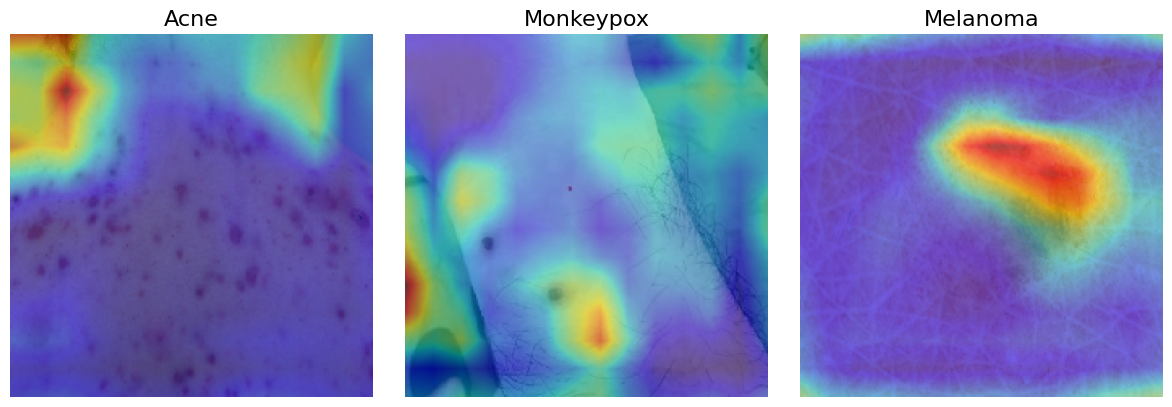

CPU times: total: 25min 20s
Wall time: 8min 29s


In [30]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Faster-ScoreCAM

3/3 [==============================] - 27s 8s/step


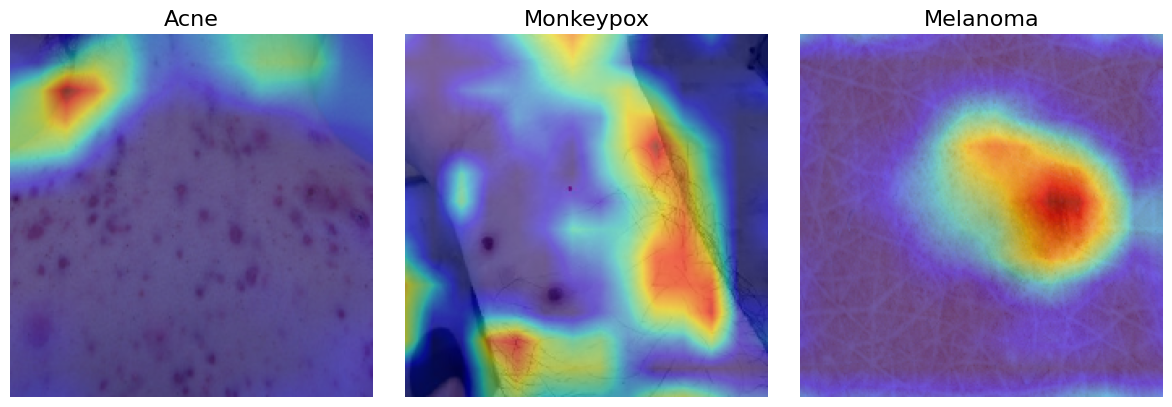

CPU times: total: 1min 26s
Wall time: 30.2 s


In [31]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()